In [1]:
import os
import numpy as np
from PIL import Image
import pybullet as p
import pybullet_data

OBJS_DIR = os.path.join('core', 'sim', 'objects')

Loading specific rearrangement: rearrangement_01810
Loading specific rearrangement: rearrangement_01810
Scene ID: 1810
Number of objects: 8
Grid size: [100, 100]
Loading specific rearrangement: rearrangement_01810


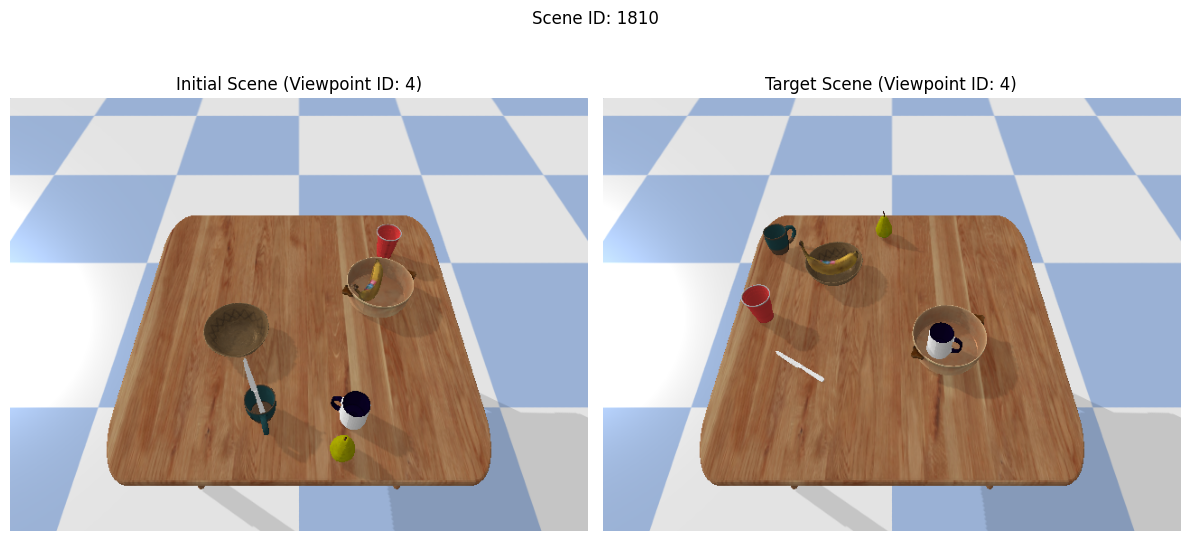

In [ ]:
from core.env.scene_manager import SceneManager
from core.env.scene_utils import scene_meta_to_x
from core.sim.rearrangemet_loader import select_rearrangement_dir, load_rearrangement_meta, visualize_rearrangement

dataset_dir = "dataset-sim"
folder_path, scene_id = select_rearrangement_dir(dataset_dir)
meta_data = load_rearrangement_meta(dataset_dir, scene_id=scene_id)

print(f"Scene ID: {meta_data.get('scene_id', 'Unknown')}")
print(f"Number of objects: {meta_data.get('num_objects', 'Unknown')}")
print(f"Grid size: {meta_data.get('grid_size', 'Unknown')}")

initial_x, target_x = scene_meta_to_x(meta_data)
env = SceneManager(
    num_objects=meta_data['num_objects'],
    grid_size=tuple(meta_data['grid_size']),
    verbose=0,
)
env.reset(initial_scene=initial_x, target_scene=target_x)
# env.render(fig_size=3)
visualize_rearrangement(dataset_dir, scene_id=scene_id)

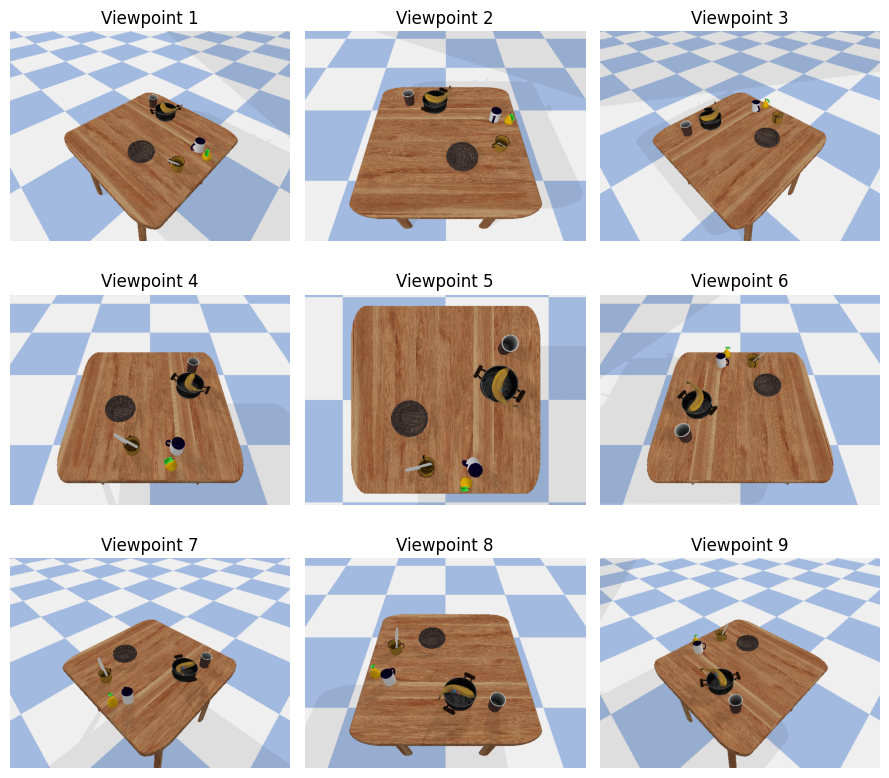

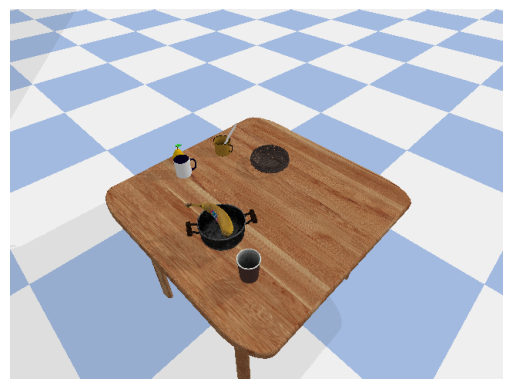

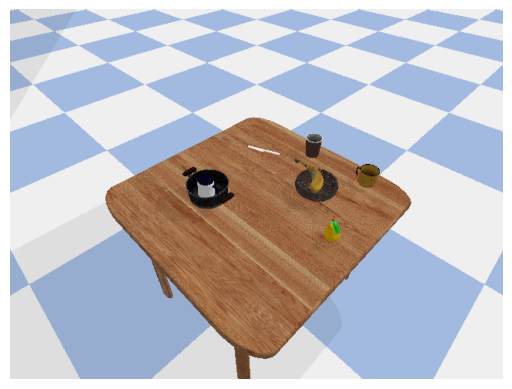

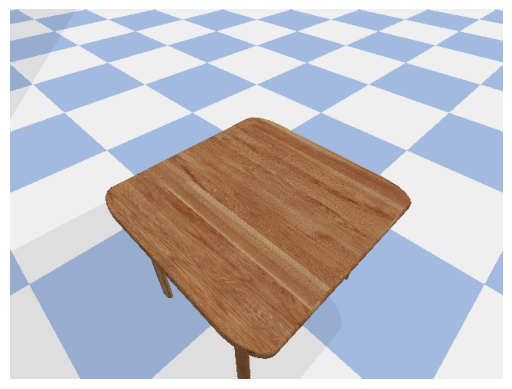

In [ ]:
from core.sim.physics_utils import PyBulletSim, load_table_urdf, get_object_extents
from core.sim.camera_manager import CameraManager
import matplotlib.pyplot as plt
from core.sim.rearrangemet_loader import generate_scene_objects_from_meta, adjust_objects_for_target_scene

sim = PyBulletSim(p.DIRECT)
table = load_table_urdf(OBJS_DIR, (100, 100))
z = get_object_extents(table)[2]
cam = CameraManager()
cam.set_viewpoint(target_pos=[0, 0, z], viewpoint_id=8)
grid_size=meta_data['grid_size']

x_range, y_range = [-0.5, 0.5], [-0.5, 0.5]
objects = generate_scene_objects_from_meta(
	OBJS_DIR, meta_data, x_range, y_range, z, grid_size=grid_size,
	target_mode=False,
)

sim.step(1)

fig, ax = plt.subplots(3, 3, figsize=(9, 9))
for i in range(9):
    cam.set_viewpoint(target_pos=[0, 0, z], viewpoint_id=i+1)
    ax[i//3, i%3].imshow(cam.capture_image())
    ax[i//3, i%3].set_title(f"Viewpoint {i+1}")
    ax[i//3, i%3].axis('off')
    plt.tight_layout()
plt.show()

cam.show_img(cam.capture_image())

objects = adjust_objects_for_target_scene(objects, meta_data, x_range, y_range, z, grid_size=grid_size)
for obj in objects:
	orn = p.getQuaternionFromEuler(obj['final_orn'])
	p.resetBasePositionAndOrientation(obj['body_id'], obj['final_pos'], orn)

sim.step(1)

cam.show_img(cam.capture_image())

sim.close()

# Image to Meta

In [ ]:
from core.env.scene_manager import OBJECTS
from core.sim.rearrangemet_loader import load_scene_objects_from_labels, world_to_grid_coords

sim = PyBulletSim(p.DIRECT)
table = load_table_urdf(OBJS_DIR, (100, 100))
z = get_object_extents(table)[2]
cam = CameraManager()
cam.set_viewpoint(target_pos=[0, 0, z], viewpoint_id=8)

objects = load_scene_objects_from_labels(OBJS_DIR, folder_path)

sim.step(2)

bboxes, labels, vis_ratios = [], [], []
for obj in objects:
	bbox, vis_ratio = cam.compute_2d_bounding_box(OBJS_DIR, obj['model_name'], obj['body_id'], obj['body_type'])
	bbox_size = ((bbox[2] - bbox[0]) * (bbox[3] - bbox[1]))
	u, v = (bbox[0] + bbox[2]) / 2, (bbox[1] + bbox[3]) / 2
	obj_pos = cam.project_pixel_to_world(u, v, n=np.array([0, 0, 1]), p0=np.array([0, 0, z+0.05]))
	grid_pos = world_to_grid_coords(obj_pos, world_x_range=[-0.5, 0.5], world_y_range=[-0.5, 0.5], grid_size=(100, 100))
	label = next((k for k, v in OBJECTS.items() if v['name'] == obj['model_name']), None)
	print(label, grid_pos)

	if bbox is None or vis_ratio < 0.3 or bbox_size < 400:
		print(f"Object {obj['object_id']} ({obj['model_name']}) is not sufficiently visible.")

	bboxes.append(bbox)
	labels.append(f"{obj['model_name']}_{obj['object_id']}")
	vis_ratios.append(vis_ratio)
	print(f"{obj['object_id']} ({obj['model_name']}) - VR: {vis_ratio:.2f} - BB: {bbox_size}")

cam.draw_2d_bounding_boxes(cam.capture_image(), bboxes, labels)

sim.close()

In [ ]:
import pathlib
import torch
pathlib.PosixPath = pathlib.WindowsPath

model_path = f'perception/final_yolov5l/weights/best.pt'
model = torch.hub.load('ultralytics/yolov5', 'custom', path=model_path, force_reload=True, device='cpu')

In [ ]:
img_unseen = Image.open(f"dataset/rearrangement_00001/initial_image.png")
results = model(img_unseen)
# results.pandas().xyxy
results.show()

# Tilt

In [6]:
from core.sim.physics_utils import PyBulletSim, load_object_urdf, get_object_extents, apply_random_tilt

sim = PyBulletSim(p.GUI)
# sim = PyBulletSim(p.DIRECT)
cam = CameraManager(target_pos=[0.5, 0, 1], distance=0.1, yaw=90, pitch=-40, roll=0)
table = load_table_urdf(OBJS_DIR, (100, 100))
z = get_object_extents(table)[2]
print(get_object_extents(table))
load_object_urdf(OBJS_DIR, 'basket', [0.3, -0.15, z+0.05], body_type=3, use_fixed_base=True)
# mug_orn = [0, 0, random.uniform(0, 2 * np.pi)]
mug_orn = [0, 0, np.pi/1.5]
load_object_urdf(OBJS_DIR, 'mug',    [0.3, -0.15, z+0.1], mug_orn, body_type=3)
pos, orn = [0.3, -0.15, z+0.2], [np.pi / 2, 0, 0]
pos, orn = apply_random_tilt(pos, orn, max_shift=0.01, tilt_angle=10)
load_object_urdf(OBJS_DIR, 'spoon',  pos, orn)

# sim.step(20)
load_object_urdf(OBJS_DIR, 'mug',    [0.3, 0.15, z+0.08], mug_orn, body_type=3)
load_object_urdf(OBJS_DIR, 'spoon',  pos+[0, 0.3, 0], orn)

sim.run()
sim.close()

[1.05599995 1.05599995 0.7750002 ]
